# Test and classification

In [ ]:
path_train = '/content/drive/MyDrive/Projet Twitter/df_by_period_nuit_tweets_len.csv'
path_test = '/content/drive/MyDrive/Projet Twitter/df_test_nuit_tweets_len.csv'

path_cosine_train = '/content/drive/MyDrive/Projet Twitter/keyword_emotion_features_trainset.csv'
path_cosine_test = '/content/drive/MyDrive/Projet Twitter/keyword_emotion_features_testset.csv'

If need for mounting from a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import useful libraries and modules

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sb
import openpyxl
import plotly.express as px
import plotly.graph_objects as go
import torch
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import os
import re
import gensim.downloader as api
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_decomposition import PLSRegression
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
df_train_nuit = pd.read_csv(path_train)
df_test_nuit = pd.read_csv(path_test)

df_cosine = pd.read_csv(path_cosine_train)
df_cosine_test = pd.read_csv(path_cosine_test)

df_train_nuit = pd.merge(df_train_nuit, df_cosine[['ID', 'score_cosine']], on='ID', how='inner')
df_test_nuit = pd.merge(df_test_nuit, df_cosine_test[['ID', 'score_cosine']], on='ID', how='inner')


In [ ]:
df_vec = df_train_nuit.drop(['PeriodID', 'ID', 'TweetCount', 'GrowthRate', 'nb_tweets_normalize',
       'rate_increase', 'TotalEmojiCount', 'TotalExcessivePunctCount',
       'AvgUppercaseRatio', 'EventType', 'score_cosine', 'AvgTweetLength'], axis=1)
df_features = df_train_nuit[['PeriodID', 'nb_tweets_normalize',
       'rate_increase', 'TotalEmojiCount', 'TotalExcessivePunctCount',
       'AvgUppercaseRatio', 'EventType', 'score_cosine', 'AvgTweetLength']]
scaler_vec = StandardScaler()
scaler_vec.fit(df_vec)
df_vec = scaler_vec.transform(df_vec)

PCA_vec = PCA(n_components=20, random_state=42)
PCA_vec.fit(df_vec)
df_vec = PCA_vec.transform(df_vec)
df_vec = pd.DataFrame(df_vec)

df_vec['EventType'] = df_train_nuit['EventType']

df_vec.columns = df_vec.columns.astype(str)

#df_vec= df_vec[['13', '14', '16', 'EventType']]
df_vec['ID'] = df_train_nuit['ID']

#corr_vec = df_vec.corr()
#corr_vec.style.background_gradient(cmap='coolwarm')

df_vec.drop('EventType', axis=1, inplace=True)

In [ ]:
df_train = pd.merge(df_train_nuit[['PeriodID', 'ID', 'nb_tweets_normalize',
       'rate_increase', 'TotalEmojiCount', 'TotalExcessivePunctCount',
       'AvgUppercaseRatio', 'EventType', 'score_cosine', 'AvgTweetLength']],df_vec, on='ID', how='inner')
df_train

,PeriodID,ID,nb_tweets_normalize,rate_increase,TotalEmojiCount,TotalExcessivePunctCount,AvgUppercaseRatio,EventType,score_cosine,AvgTweetLength,...,10,11,12,13,14,15,16,17,18,19
0,0,11_0,0.005133,0.000000,0.001085,0.001315,0.160719,0,138,62.303907,...,6.065827,-7.378223,-0.160360,-2.103493,3.735517,0.002671,0.356633,-0.053642,-0.212899,3.378227
1,1,11_1,0.005230,1.881331,0.000869,0.001159,0.180216,0,153,58.730114,...,6.514005,-7.602618,-0.058525,-2.272341,3.735516,-1.172209,0.623692,-0.460010,-0.222470,3.873751
2,2,11_10,0.005720,9.375000,0.000958,0.001263,0.183618,1,314,51.465330,...,8.055454,-8.345184,-0.103812,-2.656581,2.650617,-2.394175,1.856217,-2.916688,-0.722242,4.612255
3,3,11_100,0.007154,25.064935,0.001501,0.001575,0.182333,0,212,69.292237,...,0.213384,0.537662,-1.523789,-1.594596,-0.588722,1.426845,-0.344207,0.182206,0.175024,0.936158
4,4,11_101,0.007570,5.815161,0.001746,0.001946,0.184007,0,220,65.685307,...,-0.355309,0.404640,-1.009005,-0.916981,-0.688626,0.672800,0.284621,-0.851663,0.072554,0.416713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,125,18_95,0.016364,-23.582766,0.000599,0.005422,0.103526,0,31,81.502825,...,3.618114,2.347652,0.391040,-1.302906,-3.648984,1.333108,0.571951,1.087196,-2.194675,0.050370
2133,126,18_96,0.013159,-19.584570,0.000178,0.003885,0.108232,1,158,66.341954,...,0.272286,5.359005,-2.042751,0.710727,-6.145087,-2.038986,1.250731,-3.016894,0.039833,2.661890
2134,127,18_97,0.012253,-6.888069,0.000356,0.003966,0.109869,1,113,69.521246,...,1.284076,3.946740,-0.786303,0.921941,-3.315270,-3.224669,4.361688,-0.870208,-1.754266,0.841478
2135,128,18_98,0.010747,-12.285337,0.000421,0.003545,0.106302,1,73,77.674576,...,2.165294,3.728177,-0.045673,-0.849871,-3.859529,0.449519,2.352049,0.610339,-0.936386,0.208081


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
X = df_train.drop(['EventType', 'ID'], axis=1)
y = df_train['EventType']
xgb_model = XGBClassifier(objective='binary:logistic',
      random_state=42)
cross_val_results = cross_val_score(xgb_model, X, y, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

Cross-Validation Results (Accuracy): [0.78271028 0.77102804 0.74004684 0.73067916 0.79391101]
Mean Accuracy: 0.7636750640197858


In [ ]:
X = df_train.drop(['EventType', 'ID'], axis=1)
y = df_train['EventType']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import GridSearchCV

# Définir la grille des hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3],
    'reg_alpha':[0.1],
    'reg_lambda':[0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score d'accuracy : ", grid_search.best_score_)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Meilleurs paramètres :  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}
Meilleur score d'accuracy :  0.7694529234627283


0.7827102803738317

In [ ]:
best_xgb = xgb_model

df_test_vec = df_test_nuit.drop(['PeriodID', 'ID', 'TweetCount', 'GrowthRate', 'nb_tweets_normalize',
       'rate_increase', 'TotalEmojiCount', 'TotalExcessivePunctCount',
       'AvgUppercaseRatio', 'score_cosine', 'AvgTweetLength'], axis=1)
df_test_vec = scaler_vec.transform(df_test_vec)
df_test_vec = PCA_vec.transform(df_test_vec)
df_test_vec = pd.DataFrame(df_test_vec)
df_test_vec.columns = df_test_vec.columns.astype(str)
df_test_vec['ID'] = df_test_nuit['ID']
df_test = pd.merge(df_test_nuit[['PeriodID', 'ID', 'nb_tweets_normalize',
       'rate_increase', 'TotalEmojiCount', 'TotalExcessivePunctCount',
       'AvgUppercaseRatio', 'score_cosine', 'AvgTweetLength']],df_test_vec, on='ID', how='inner')
y_pred = best_xgb.predict(df_test.drop(['ID'], axis=1))
y = pd.DataFrame()
y['ID'] = df_test_nuit['ID']
y['EventType'] = y_pred
y.to_csv('/content/drive/MyDrive/Projet Twitter/y_pred13.csv', index=False)

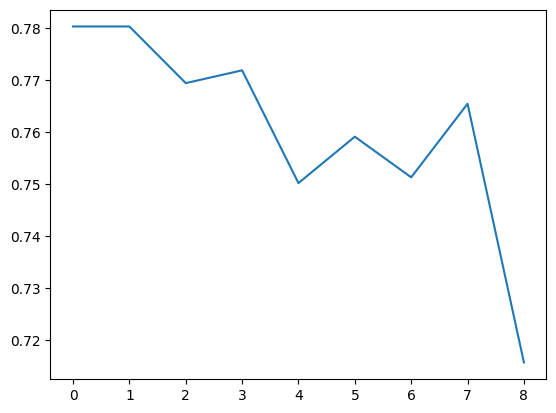

In [ ]:
list_acc = []
for k in range(1,10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k/10, random_state=42) # Call train_test_split with correct arguments
  xgb_model.fit(X_train, y_train) # Removed .values since XGBoost can handle pandas DataFrames directly.
  y_pred = xgb_model.predict(X_test)
  list_acc.append(accuracy_score(y_test, y_pred))

plt.plot(list_acc)